<a href="https://colab.research.google.com/github/JoseFRuiz/solarsitedaptation/blob/main/site_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accurate Solar Radiation Site Adaptation: Harnessing Satellite Data and In Situ Measurements



# Setup

In [1]:
import calendar
import numpy as np
import os
import pandas as pd
import random
import shutil
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
### Neural network Pytorch settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # You can use other activation functions like nn.Sigmoid() or nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [3]:
### Input variables

# input_variables = ['GHI','Temperature', 'Relative Humidity', 'Surface Albedo']
# input_variables = ['GHI','Temperature']
# input_variables = ['GHI','Relative Humidity']
# input_variables = ['GHI','Surface Albedo']
input_variables = ['GHI']

In [4]:
clip_val = 30

output_folder = "output"


if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

try:
    os.makedirs(os.path.join(output_folder))
except:
    print(f"Folder {output_folder} already exists or can not be created")

num_vars = len(input_variables)

def dateGeneratorFun(year):
    # Example: datelist = [date for date in dateGeneratorFun(2017)]
    st_date = [year,1,1]
    st_date = pd.Timestamp(*st_date)
    n_days = 366 if calendar.isleap(year) else 365
    for iday in range(n_days):
        date = st_date + pd.DateOffset(iday)
        yield date

def randomdate(year):
  if calendar.isleap(year):
    rdelta = random.sample(range(366),1)[0]
  else:
    rdelta = random.sample(range(365),1)[0]
  st_date = [year,1,1]
  st_date = pd.Timestamp(*st_date)
  date = st_date + pd.DateOffset(rdelta)
  return date

def get_input_output(st_date):
  en_date = st_date + pd.DateOffset(1)
  st_time = st_date + pd.DateOffset(hours=6)
  en_time = st_date + pd.DateOffset(hours=18)
  st_time_gd = st_date + pd.DateOffset(hours=7)
  en_time_gd = st_date + pd.DateOffset(hours=19)
  # Input
  dfsel = df[(df.index.array>=st_date) & (df.index.array<en_date)][input_variables].copy()
  dfsel = dfsel[(dfsel.index.array>=st_time) & (dfsel.index.array<=en_time)]
  x = []
  for hour in pd.date_range(start=st_time, end=en_time, freq='H'):
    if len(dfsel[dfsel.index==hour])>0:
        x.append(dfsel[dfsel.index==hour].values[0])
    else:
        x.append(np.asarray(num_vars*[np.nan]))

  # Output
  dfgdsel = dfgd[(dfgd.index.array>=st_date) & (dfgd.index.array<en_date)]['Valor'].copy()
  dfgdsel = dfgdsel[(dfgdsel.index.array>=st_time_gd) & (dfgdsel.index.array<=en_time_gd)]
  y = []
  for hour in pd.date_range(start=st_time_gd, end=en_time_gd, freq='H'):
    if len(dfgdsel[dfgdsel.index==hour])>0:
        y.append(dfgdsel[dfgdsel.index==hour].values[0])
    else:
        y.append(np.nan)
  return x, y

# Load data

In [5]:
!git clone https://github.com/JoseFRuiz/solarsitedaptation

Cloning into 'solarsitedaptation'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 3), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (16/16), 460.23 KiB | 6.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [6]:
awsdata_nsrdb_file = "solarsitedaptation/awsdata_nsrdb.csv"
awsdata_ground_file = "solarsitedaptation/awsdata_ground.csv"

# df_stations = pd.DataFrame([
#   {'code': 52035040, 'name': "Viento Libre", 'lat': 1.62, 'lon': -77.34}
#                             ])

beta_dtr = 1
alpha_dpr = 1


dfgd = pd.read_csv(awsdata_ground_file)
dfgd = dfgd.set_index(pd.DatetimeIndex(dfgd['Fecha'].values))['Valor']
dfgd = pd.DataFrame(dfgd)

# Load nsrdb input data
df = pd.read_csv(awsdata_nsrdb_file,index_col=0)
df = df.set_index(pd.DatetimeIndex(df.index.values))[input_variables]
df = pd.DataFrame(df)

data_dict = {}
trainyear, testyear = 2017, 2018
data_mode_year = {'train': trainyear,'test': testyear}


for key in data_mode_year.keys():
    print("Generating training test sets", key,data_mode_year[key])

    X, Y, date_list = [], [], []
    for date in dateGeneratorFun(data_mode_year[key]):
        xaux,yaux = get_input_output(date)
        X.append(xaux)
        Y.append(yaux)
        date_list.append(date)

    X = np.stack(X)
    X = X.reshape(X.shape[0],-1)
    Y = np.stack(Y)
    date_list = np.stack(date_list)
    date_list = date_list[np.logical_not(np.isnan(Y.sum(1)))]
    X = X[np.logical_not(np.isnan(Y.sum(1)))]
    Y = Y[np.logical_not(np.isnan(Y.sum(1)))]

    Xnrel = X[:,::num_vars].copy()
    Ydiff = (Xnrel-Y)/beta_dtr

    if key=='train':
        scalerX = preprocessing.StandardScaler().fit(X)
        scalerY = preprocessing.StandardScaler().fit(Ydiff)

    X = scalerX.transform(X)
    Ydiff_norm = scalerY.transform(Ydiff)

    data_dict["dates_%s"%key] = date_list
    data_dict["X_%s"%key], data_dict["Y_%s"%key] = X, Y
    data_dict["Xnrel_%s"%key] = Xnrel
    data_dict["Ydiff_norm_%s"%key], data_dict["Ydiff_%s"%key] = Ydiff_norm, Ydiff

Generating training test sets train 2017
Generating training test sets test 2018


# Training

In [13]:
### Neural network regression
regr = MLPRegressor(hidden_layer_sizes=(13,13,13),random_state=1,
                    max_iter=int(1e5), solver='sgd', learning_rate_init=1e-6,
                    learning_rate='adaptive', tol = 1e-6, batch_size = 100,
                    activation='relu').fit(data_dict['X_train'], data_dict['Ydiff_norm_train'])


Ypred = regr.predict(data_dict['X_test'])
perclippedMLPR = (Ypred[Ypred<-2].shape[0]+Ypred[Ypred>2].shape[0])/Ypred.shape[0]
print("Percentage clipped MLPR: ", 100*perclippedMLPR)
Ypred = np.clip(Ypred,-2,2)
Ypred = scalerY.inverse_transform(Ypred)
Ypred = np.clip(Ypred,-clip_val,clip_val)
data_dict['Y_test_pred'] = np.clip(data_dict['Xnrel_test']-alpha_dpr*Ypred,0,2000)

regrAE = MLPRegressor(hidden_layer_sizes=(16,8,2,8,16),random_state=1,
                    max_iter=int(1e5), solver='sgd', learning_rate_init=1e-6,
                    learning_rate='adaptive', tol = 1e-6, batch_size = 100,
                    activation='relu').fit(data_dict['X_train'], data_dict['Ydiff_norm_train'])

Ypred = regrAE.predict(data_dict['X_test'])
Ypred = np.clip(Ypred,-2,2)
Ypred = scalerY.inverse_transform(Ypred)
Ypred = np.clip(Ypred,-clip_val,clip_val)
data_dict['Y_test_predAE'] = np.clip(data_dict['Xnrel_test']-alpha_dpr*Ypred,0,2000)


### Neural network with triplet loss
Xaux, Yaux = data_dict["X_train"], data_dict["Y_train"]
Xori = scalerX.inverse_transform(Xaux)
Xori_tensor = torch.Tensor(Xori).to(device)
Y_tensor = torch.Tensor(Yaux).to(device)

input_size = Xori.shape[1]
hidden_size = 64  # Adjust the number of hidden units as needed
output_size = Y.shape[1]

model = MyNetwork(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
triplet_loss = nn.TripletMarginLoss(margin=0.1, p=1, eps=1e-7)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(Xori_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model:
num_epochs = 200

for epoch in range(num_epochs):
    for negative_inputs, positive_targets in dataloader:
        optimizer.zero_grad()
        anchor_outputs = model(negative_inputs)
        loss = criterion(anchor_outputs, positive_targets)
        loss += triplet_loss(anchor_outputs, positive_targets, negative_inputs[:,:13])
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')


Xtest, Ytest = data_dict["X_test"], data_dict["Y_test"]
Xtest = scalerX.inverse_transform(Xtest)
Xtest_tensor = torch.Tensor(Xtest).to(device)

# After training, you can use the trained model to make predictions:
with torch.no_grad():
    model.eval()
    predicted_Y = model(Xtest_tensor)
    model.train()

data_dict['Y_test_predNNtriploss'] = np.clip(predicted_Y.cpu().numpy(),0,2000)


### XGBoost regression
regr = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error)
regr.fit(data_dict['X_train'], data_dict['Ydiff_norm_train'])


Ypred = regr.predict(data_dict['X_test'])
perclippedXGB = (Ypred[Ypred<-2].shape[0]+Ypred[Ypred>2].shape[0])/Ypred.shape[0]
print("Percentage clipped XGB: ", 100*perclippedXGB)
Ypred = np.clip(Ypred,-2,2)
Ypred = scalerY.inverse_transform(Ypred)
Ypred = np.clip(Ypred,-clip_val,clip_val)
data_dict['Y_test_pred_xgboost'] = np.clip(data_dict['Xnrel_test']-alpha_dpr*Ypred,0,2000)
# data_dict['Y_test_pred_xgboost'] = data_dict['Xnrel_test']-alpha_dpr*regr.predict(data_dict['X_test'])

### Support vector machine regression
Ypredsvr = data_dict['Xnrel_test'].copy()

for ihour, yout in enumerate(data_dict['Ydiff_norm_train'].transpose()):
    regr = SVR(kernel='rbf',C=100.0, epsilon=0.2).fit(data_dict['X_train'], yout)
    Ypredsvr[:,ihour]=regr.predict(data_dict['X_test'])

perclippedSVR = (Ypredsvr[Ypredsvr<-2].shape[0]+Ypredsvr[Ypredsvr>2].shape[0])/Ypredsvr.shape[0]
print("Percentage clipped SVR: ", 100*perclippedSVR)
Ypredsvr = np.clip(Ypredsvr,-2,2)
Ypred = scalerY.inverse_transform(Ypredsvr)
Ypred = np.clip(Ypred,-clip_val,clip_val)
data_dict['Y_test_pred_svr'] = np.clip(data_dict['Xnrel_test']-alpha_dpr*Ypred,0,2000)



### Saving data
data_dict["X_test"] = scalerX.inverse_transform(X)
data_dict["Y_test"] = Y

df = {'date': list(data_dict["dates_test"])}
for i, vec in enumerate(data_dict['Xnrel_test'].transpose()):
    day_time = i+6
    df['NREL_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test'].transpose()):
    day_time = i+6
    df['GT_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test_pred'].transpose()):
    day_time = i+6
    df['NNpred_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test_predAE'].transpose()):
    day_time = i+6
    df['NNAEpred_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test_predNNtriploss'].transpose()):
    day_time = i+6
    df['NNtriplosspred_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test_pred_xgboost'].transpose()):
    day_time = i+6
    df['XGBpred_%02d'%day_time] = list(vec)

for i, vec in enumerate(data_dict['Y_test_pred_svr'].transpose()):
    day_time = i+6
    df['SVRpred_%02d'%day_time] = list(vec)

Percentage clipped MLPR:  0.0
Epoch 1/200, Loss: 44769.0508
Epoch 2/200, Loss: 27030.6328
Epoch 3/200, Loss: 11610.6094
Epoch 4/200, Loss: 13246.5508
Epoch 5/200, Loss: 11774.3359
Epoch 6/200, Loss: 11292.0234
Epoch 7/200, Loss: 11845.1553
Epoch 8/200, Loss: 10209.3438
Epoch 9/200, Loss: 11482.3877
Epoch 10/200, Loss: 10235.0752
Epoch 11/200, Loss: 9266.2490
Epoch 12/200, Loss: 7437.1250
Epoch 13/200, Loss: 9446.1465
Epoch 14/200, Loss: 9117.4746
Epoch 15/200, Loss: 9333.6045
Epoch 16/200, Loss: 7980.3965
Epoch 17/200, Loss: 9172.3672
Epoch 18/200, Loss: 9358.6270
Epoch 19/200, Loss: 7346.9951
Epoch 20/200, Loss: 13792.2158
Epoch 21/200, Loss: 6359.8374
Epoch 22/200, Loss: 7927.5210
Epoch 23/200, Loss: 6759.6318
Epoch 24/200, Loss: 7342.9780
Epoch 25/200, Loss: 6139.9058
Epoch 26/200, Loss: 8137.8643
Epoch 27/200, Loss: 7233.9097
Epoch 28/200, Loss: 9087.7383
Epoch 29/200, Loss: 10155.3330
Epoch 30/200, Loss: 6733.6426
Epoch 31/200, Loss: 9765.9512
Epoch 32/200, Loss: 8315.2227
Epoch 3

# Saving results

In [ ]:
df = pd.DataFrame(df)
output_file = os.path.join(output_folder,"site_adaptation.csv")
df.to_csv(output_file)

# Visualization

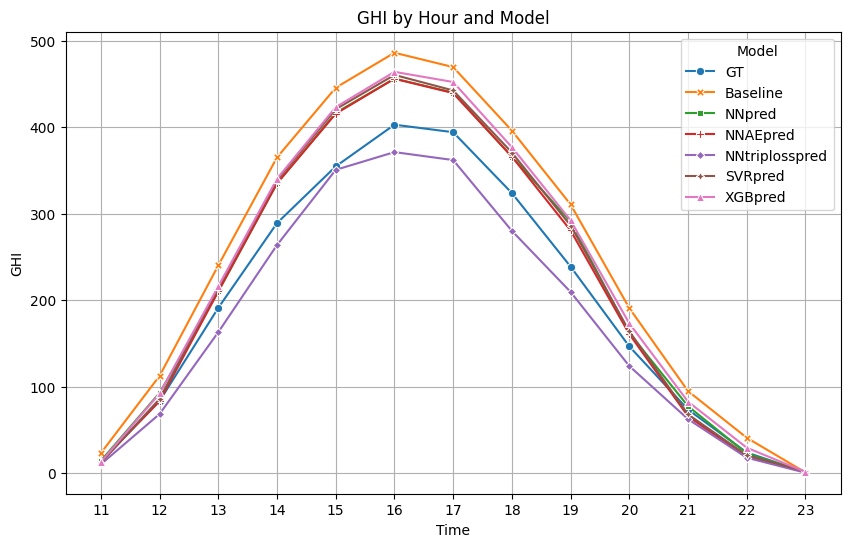

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def meanbyHH(csvpathfile=None, modstr="GT"):
    df = pd.read_csv(csvpathfile)
    dfsel = pd.DataFrame({'ID': range(1, len(df) + 1)})

    for hh in range(6, 19):
        hhstr = f"{hh:02d}"
        colsel = f"{modstr}_{hhstr}"
        dfsel[hhstr] = df[colsel]

    melt_data = pd.melt(dfsel, id_vars=['ID'], var_name='HH', value_name='GHI')

    dfmean = melt_data.groupby('HH').agg({'GHI': 'mean'}).reset_index()

    return dfmean

csvpathfile = "output/site_adaptation.csv"

modlist = ["GT", "NREL", "NNpred", "NNAEpred", "NNtriplosspred", "SVRpred", "XGBpred"]
df = pd.DataFrame()

for modstr in modlist:
    dfmean = meanbyHH(csvpathfile, modstr)
    # Change NREL to Baseline
    if modstr == "NREL":
        dfmean['Model'] = "Baseline"
    else:
        dfmean['Model'] = modstr
    df = pd.concat([df, dfmean], ignore_index=True)

df['HH'] = df['HH'].astype(int) + 5

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='HH', y='GHI', hue='Model', style='Model', markers=True, dashes=False)

plt.xlabel("Time")
plt.xticks(np.arange(df['HH'].min(), df['HH'].max() + 1, 1))
plt.title("GHI by Hour and Model")
plt.legend(title='Model')
plt.grid(True)
plt.show()